In [240]:
%run 'Functions.ipynb'

In [2]:
client = Elasticsearch()

In [3]:
ids = [e.meta.id for e in Search(index='hep-recent').fields(['_id']).scan()]

In [4]:
len(ids)

99999

In [5]:
def term_vectors(ids, field):
    res = client.mtermvectors(
        index='hep-analysis', 
        doc_type='hep',
        ids=ids,
        fields=[field],
        field_statistics=False,
        term_statistics=True,
        offsets=False,
        payloads=False,
        positions=False
    )
    return [e['term_vectors'][field]['terms'] for e in res['docs'] if field in e['term_vectors']]

In [6]:
res = term_vectors(ids[0:100], 'abstracts.value')

In [7]:
word_freq = {}

In [8]:
for i in range(0, 500):
    vectors = term_vectors(ids[100 * i:100 * i + 100], 'abstracts.value')
    for vec in vectors:
        for word, freq in vec.items():
            if word not in word_freq:
                word_freq[word] = freq['ttf']

In [9]:
len(word_freq)

2099479

In [10]:
word_ordered = sorted(word_freq.items(), key=lambda x: -x[1])
word_ordered[:20]

[('model', 53570),
 ('use', 45261),
 ('result', 37965),
 ('show', 33273),
 ('present', 28955),
 ('study', 28790),
 ('energy', 27955),
 ('find', 27456),
 ('can', 27035),
 ('inline', 25917),
 ('mass', 25819),
 ('field', 25337),
 ('theory', 24478),
 ('data', 22741),
 ('two', 21410),
 ('also', 21275),
 ('large', 19463),
 ('obtain', 19364),
 ('system', 19122),
 ('inline formula', 19030)]

In [11]:
x, y = zip(*word_ordered)

In [12]:
def plot_interval(x, y, start=0, count=100):
    plt.xlim(start, start + count)
    plt.xticks(range(start, start + count), x[start:start + count], rotation=90)
    plt.plot(y)

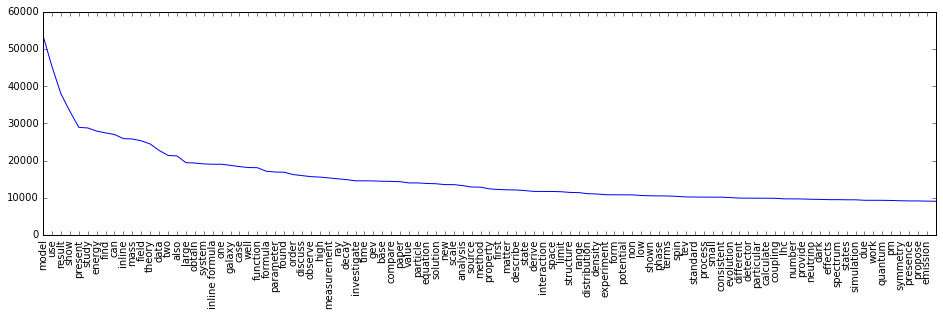

In [13]:
plot_interval(x, y)

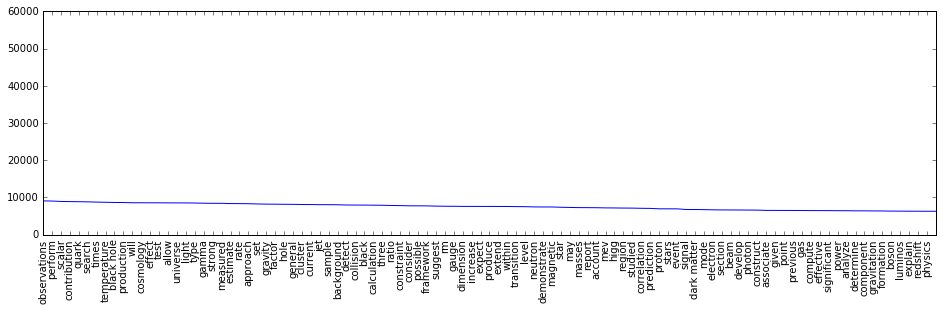

In [14]:
plot_interval(x, y, 100)

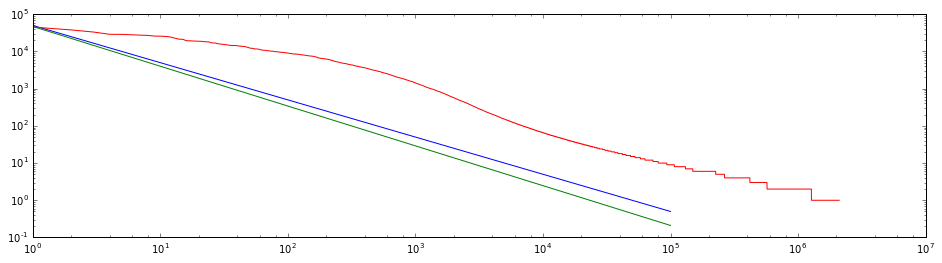

In [47]:
plt.xscale('log')
plt.yscale('log')
plt.plot(5e9 * sp.stats.zipf.pmf(range(100000), 1.00001))
plt.plot(7e5 * sp.stats.zipf.pmf(range(100000), 1.07))
plt.plot(y)

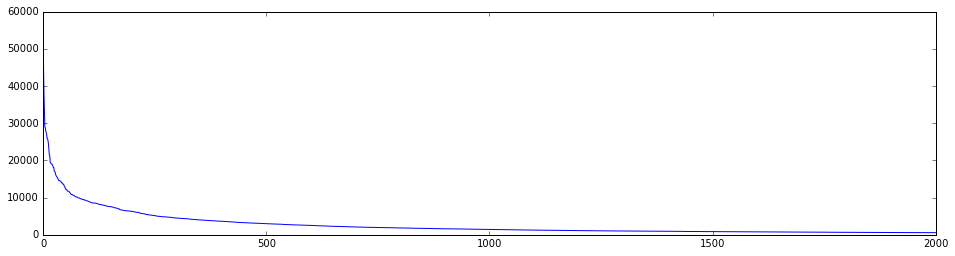

In [30]:
plt.xlim(0, 2000)
plt.plot(y)

In [16]:
word_freq['higg']

7185

In [17]:
from wordcloud import WordCloud

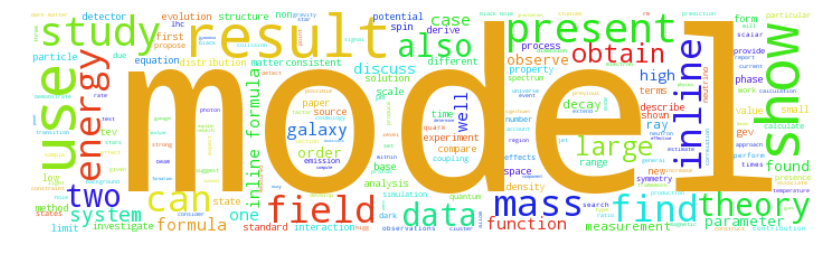

In [18]:
plt.axis("off")
plt.imshow(WordCloud(width=700, background_color='white').generate_from_frequencies(word_freq.items()))

In [32]:
len([k for k, v in word_freq.items() if v >= 500])

2179

2179

In [100]:
def last_week_words(start='2013-05-01', end='2013-05-07'):
    q = Search(index='hep-analysis') \
        .fields(['self_recid']) \
        .filter('range', earliest_date={'gte': start, 'lt': end}) \
        .filter('exists', field='abstracts.value')
    
    ids = []
    for e in q.scan():
         ids.append(e.meta.id)
    
    return ids

In [101]:
len(last_week_words())

477

In [253]:
def interval_ids(date, days=7):
    start_date = datetime.strptime(date, '%Y-%m-%d')
    end_date = start_date + timedelta(days=days)
    q = Search(index='hep-analysis') \
        .fields(['self_recid']) \
        .filter('range', earliest_date={'gte': start_date, 'lt': end_date}) \
        .filter('exists', field='abstracts.value')
    
    res = []
    for e in q.scan():
        res.append(e.meta.id)
    
    return res

In [150]:
def term_vectors(ids, field, chunk=100):
    res = []
    for pos in range(0, len(ids), chunk):
        q = client.mtermvectors(
            index='hep-analysis', 
            doc_type='hep',
            ids=ids[pos:pos + chunk],
            fields=[field],
            field_statistics=False,
            term_statistics=True,
            offsets=False,
            payloads=False,
            positions=False,
            realtime=True
        )
        for e in q['docs']:
            if field in e['term_vectors']:
                res.append(e['term_vectors'][field]['terms'])
    assert len(ids) == len(res)
    return res

In [227]:
def fold_vectors(vectors):
    words = {}
    for vec in vectors:
        for word, freqs in vec.items():
            if word in words:
                #assert words[word]['term_total'] == freqs['ttf']
                #assert words[word]['doc_total'] == freqs['doc_freq']
                #words[word]['history'].append(freqs['doc_freq'])
                words[word]['term_freq'] += freqs['term_freq']
                words[word]['doc_freq'] += 1
            else:
                words[word] = {
                    'term_total': freqs['ttf'], # estimate
                    'doc_total': freqs['doc_freq'], # estimate
                    'term_freq': freqs['term_freq'],
                    'doc_freq': 1,
                    #'history': [freqs['doc_freq']],
                }
    return words

In [255]:
words13 = fold_vectors(term_vectors(interval_ids('2013-05-01'), 'abstracts.value'))
words14 = fold_vectors(term_vectors(interval_ids('2014-05-01'), 'abstracts.value'))

In [309]:
len([k for k, v in words13.items() if v['term_freq'] > 5])

7431

In [250]:
classified = sorted(words.items(), key=lambda x: -x[1]['term_freq'])

In [262]:
def cloud(freqs):
    image = WordCloud(width=700, background_color='white') \
        .generate_from_frequencies(freqs)
    plt.axis("off")
    plt.imshow(image)

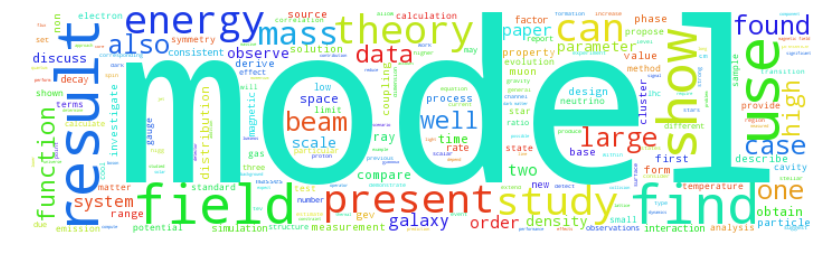

In [263]:
cloud([(k, v['term_freq']) for k, v in words13.items()])

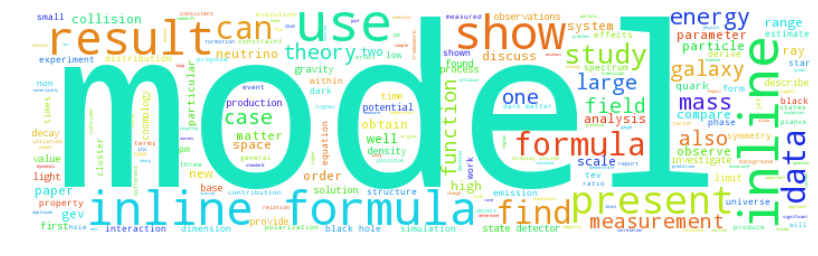

In [264]:
cloud([(k, v['term_freq']) for k, v in words14.items()])

In [271]:
y13 = {}
y14 = {}

for k, v in words13.items():
    if k not in y13:
        y13[k] = 0
    if k not in y14:
        y14[k] = 0
    y13[k] += v['term_freq']
    
for k, v in words14.items():
    if k not in y13:
        y13[k] = 0
    if k not in y14:
        y14[k] = 0
    y14[k] += v['term_freq']

In [281]:
sorted(y13)
sorted(y14)
l13, d13 = zip(*y13.items())
l14, d14 = zip(*y14.items())
assert l13 == l14

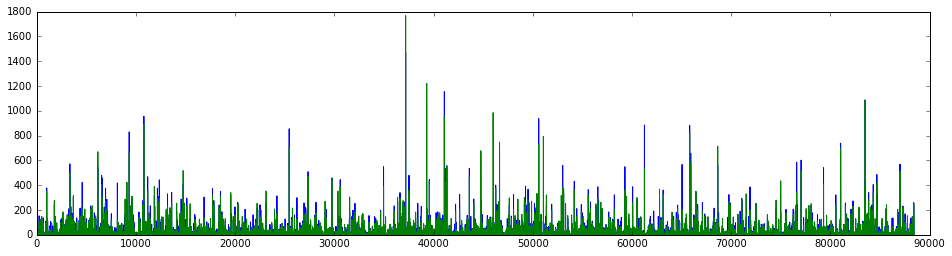

In [283]:
plt.plot(d13)
plt.plot(d14)

In [293]:
diff = np.abs(np.array(d13) - d14)

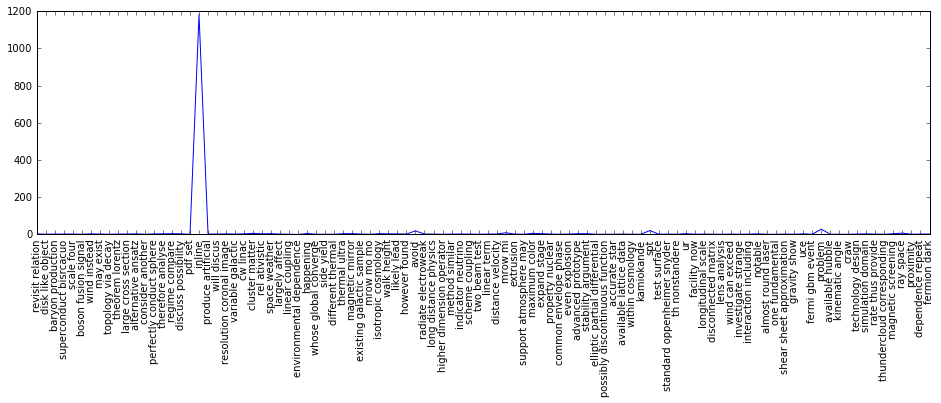

In [299]:
plt.xticks(range(100), l13[39300:39400], rotation=90)
plt.plot(diff[39300:39400])

In [300]:
words13['inline']

{'doc_freq': 3, 'doc_total': 885, 'term_freq': 40, 'term_total': 28086}

In [301]:
words14['inline']

{'doc_freq': 47, 'doc_total': 899, 'term_freq': 1221, 'term_total': 27338}